# Channel combination with Siemens twix data

In our previous example, we loaded data from the Siemens RDA format. While this is the default format for exporting MRS data from the scanner, Siemens also supports exporting the data in the twix format, which contains the true raw data before any processing is done to it. Working with twix data adds some complexity because we have to implement all the processing steps for ourselves, but it also gives us a lot more control over the methods we use and can really improve the final result. In this tutorial we are going to take a look at one of the first steps in the data processing workflow, channel combination.

As usual we start by importing the packages we will need, suspect of course, numpy for its general mathematical functionality, and matplotlib for visualising our results along the way. As this is a Jupyter notebook, we also use some IPython magic to render our plots interactively inside the notebook.

In [1]:
import suspect
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Just as in [the previous tutorial](tut1_intro.rst) we will be using data from the Suspect test data set. In this example we are using data in the twix VB format; the VD and VE formats are also supported and are generally very similar.

In [2]:
data = suspect.io.load_twix("/home/jovyan/suspect/tests/test_data/siemens/twix_vb.dat")

If we inspect the shape of the loaded data we find that there are actually 3 dimensions.

In [3]:
data.shape

(128, 32, 2048)

- The first dimension is the repetition index. Because of the low SNR in MRS, it is very common to perform the same acquisition multiple times and average the results. Because the signal is the same for every repetition, but since the noise varies randomly, overall the SNR improves by the square root of the number of repetitions. The downside to this is the increased acquisition time due to the extra repetitions. In this case we use 128 repetitions for an increase in SNR of ~11 times.
- The second dimension is the channel index. For this exam we used a 32 channel head coil.
- The final dimension is the points in the FID.

The first processing step we are going to carry out is to average over the repetitions. Each repetition is produced by running the exact same sequence so we can simply take the mean along this first axis to get a much less noisy signal.

In [4]:
repetition_averaged_data = np.mean(data, axis=0)

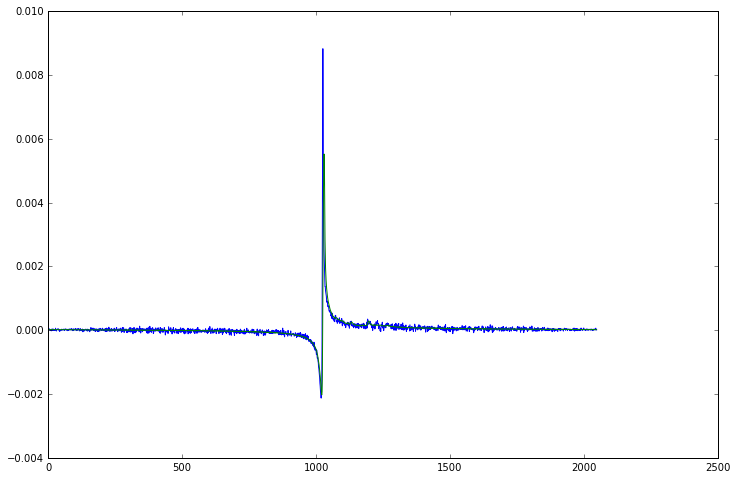

In [5]:
plt.plot(np.real(data[0, 0].spectrum()))
plt.plot(np.real(repetition_averaged_data[0].spectrum()))

Now that we have averaged all the repetitions, we have a 2D dataset of 32 FIDs, one for each channel of our head coil. You might expect that we can just average the channels in exactly the same way, after all they are all measuring the same signal at the same time. However if we plot all the FIDs together we see it isn't quite so simple as that.

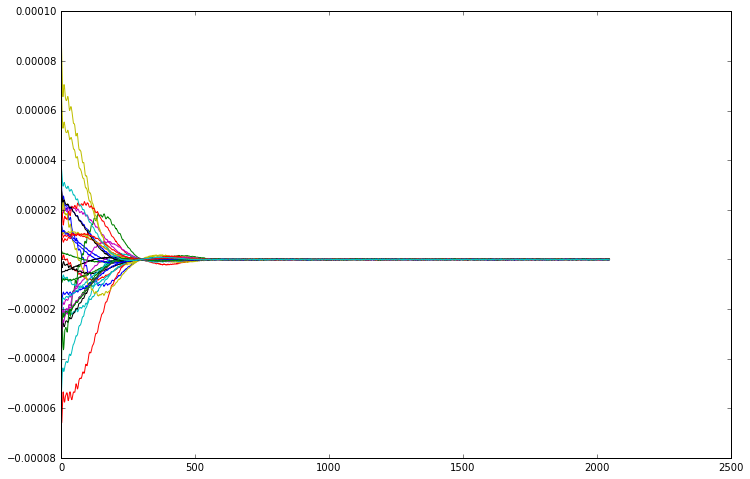

In [6]:
for i in range(32):
    plt.plot(np.real(repetition_averaged_data[i]))

Although all the channels are indeed measuring the same signal, each coil element is in a different position relative to the excitation voxel, and pointing in a different direction. This means that each channel measures the signal with a different sensitivity and phase. This is easier to see if we plot the magnitude of the FIDs, removing the phase component from the picture.

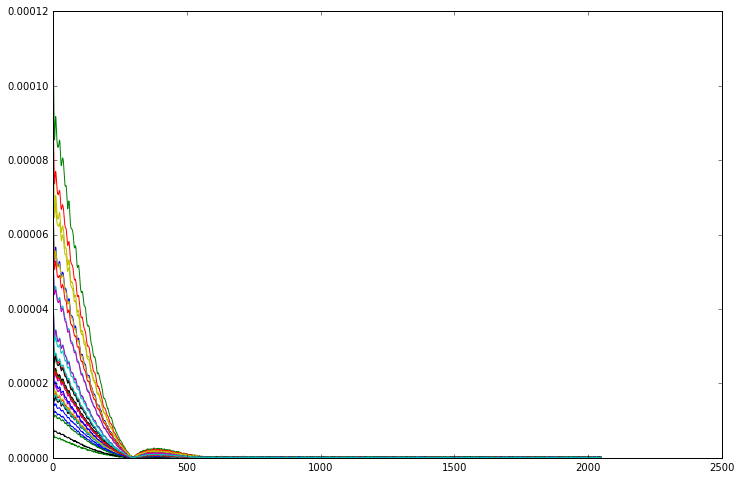

In [7]:
for i in range(32):
    plt.plot(np.abs(repetition_averaged_data[i]))

From this plot it is much easier to see that the signal from every channel has the same shape, they only differ in scale. Although in magnitude mode all the channels line up, we need to phase them before we can combine the complex FIDs.

To do this, we are going to use a very powerful technique for working with multi-dimensional MRSData objects, `numpy`'s `apply_along_axis` function. What this does is split our 2D matrix up into the individual FIDs, transform them according to a custom function, and build the results back up into a 2D matrix again. In this case, we specify a very simple function which adjusts the phase of the FID to make the first point real.

N.B. in the current version of numpy calling `apply_along_axis` will return a bare `ndarray` rather than the `MRSData` subclass, thus all the spectroscopy specific information such as f0 and dt is lost. There is a submitted pull-request to the numpy codebase to fix this issue, in the meantime we can use the `MRSData.inherit` method to copy values from the parent `MRSData` instance.

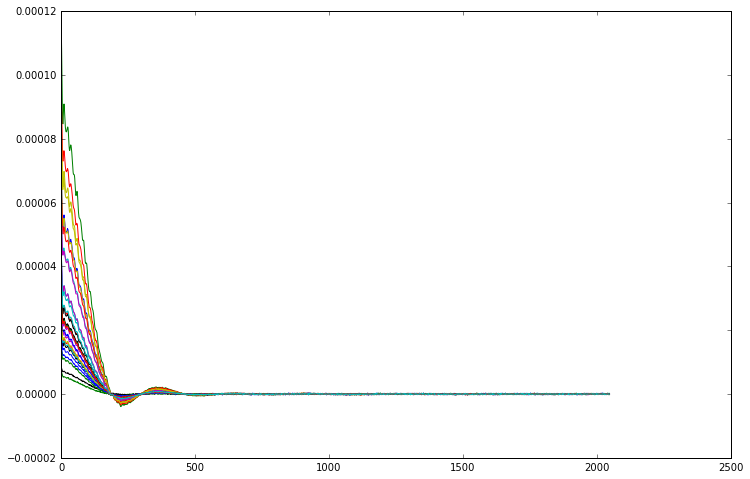

In [8]:
def phase_correct(fid):
    return fid * np.exp(-1j * np.angle(fid[0]))
phase_corrected_data = np.apply_along_axis(phase_correct, 1, repetition_averaged_data)
# copy the MRS parameters from repetition_averaged_data to phase_corrected_data
phase_corrected_data = repetition_averaged_data.inherit(phase_corrected_data)
for i in range(32):
    plt.plot(phase_corrected_data[i].real)

At this point you might be tempted to apply scaling factors to each FID to make them line up in magnitude as well as in phase, however that would be a mistake. As you can see from the right hand side of the FIDs, the level of noise is the same in each one. As the size of the signal is different for every channel, that means that the signal to noise ratio is also different. Scaling up the smaller signals to match the larger will also introduce a disproportionate amount of noise into the overall signal. Instead, we should actually scale the data to make the large signals larger and the small signals smaller, as that will give us the best SNR overall. We can modify our phase correction function to also perform this scaling, then we average over the phased and scaled channels to get the final answer. If we compare the resulting spectrum against a simple unweighted average of the phase corrected FIDs, we can see a significant boost in the SNR.

(-100, 600)

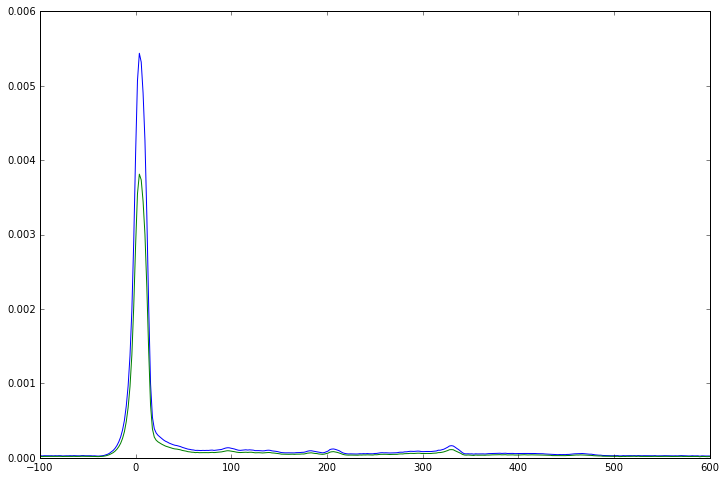

In [9]:
def phase_correct_and_scale(fid):
    return fid * np.exp(-1j * np.angle(fid[0])) * np.abs(fid[0])
scaled_data = repetition_averaged_data.inherit(
    np.apply_along_axis(phase_correct_and_scale, 1, repetition_averaged_data)
)
# we need to normalise our scaled data by the mean scaling factor so that
# on average the noise level does not change. this allows an easier
# comparison of SNR by just looking at the two signals.
scaled_data /= np.mean(np.abs(repetition_averaged_data[:, 0]))

# average 
channel_combined_data = np.mean(scaled_data, axis=0)
simple_mean = np.mean(phase_corrected_data, axis=0)

plt.plot(channel_combined_data.frequency_axis(), np.real(channel_combined_data.spectrum().real))
plt.plot(simple_mean.frequency_axis(), simple_mean.spectrum().real)
# plot only the peak region to make differences easier to see
plt.xlim([-100, 600])

So far, we have have been using the first point of each channel FID to calculate both the phase and weighting of each channel. That works well for this dataset, which has a large residual water peak, but it cannot be relied upon in all cases. In data with strong water suppression, the SNR will drop significantly, while in some cases ringing from transmitted RF or gradient coils can corrupt the initial points of the FID and require them to be suppressed.

It is preferable to use a method which can estimate the optimal channel phases and weights using the complete FID as this maximises the available SNR and gives the most robust result. A good way to achieve this is with the [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition). The SVD factorises a matrix $M$ into the product of three matrices ${U\Sigma V}^\dagger$ where $U$ and $V$ are unitary and $\Sigma$ is a non-negative real diagonal matrix. In the context of our $32\times1024$ channel $\times$ FID matrix, we can interpret $V^\dagger$ as a set of created FIDs, $\Sigma$ as the amounts of each FID in the measurement, and $U$ as the strength with which each channel measures each FID.

In [10]:
u, s, v = np.linalg.svd(repetition_averaged_data, full_matrices=False)

For this kind of single voxel data we know there is only one FID being generated, all the others should just be noise. If we print out all the singular values of our decomposition, helpfully sorted into descending order by NumPy:

In [11]:
print(s)

[  1.95606942e-03   1.68398598e-05   1.10745846e-05   8.04545743e-06
   7.00992012e-06   6.73828739e-06   6.21173379e-06   5.97860050e-06
   5.80999121e-06   5.41935388e-06   5.12515151e-06   4.92714095e-06
   4.80960584e-06   4.63161541e-06   4.50883925e-06   4.33497448e-06
   4.12607732e-06   3.98773077e-06   3.91373956e-06   3.77949787e-06
   3.64188480e-06   3.62543754e-06   3.49186287e-06   3.37929421e-06
   3.24924499e-06   3.18338310e-06   3.09072752e-06   2.96630404e-06
   2.84717143e-06   2.79823675e-06   2.69785503e-06   2.57237787e-06]


then we see immediately that the largest singular value is more than 100 times greater than the others, this is the real FID so if we truncate u, s and v to only the first row, value and column respectively then s x the first column of `v` gives us the FID, and the first row of u gives us the optimal weights. 

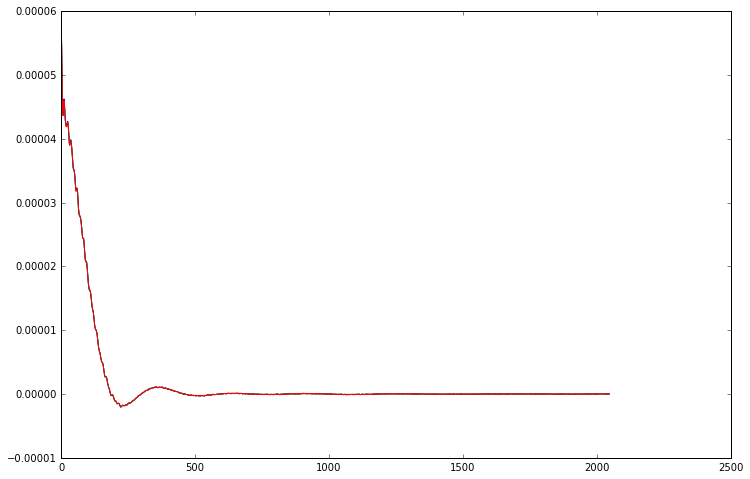

In [12]:
weights = u[:, 0].conjugate()
# we have to normalise the weights to match the previous weight calculations
weight_normalisation = np.sum(np.abs(weights))
weights /= weight_normalisation
# the FID from the SVD has an arbitrary phase difference from the previous one
phase_shift = np.angle(v[0, 0] / channel_combined_data[0])
svd_fid = np.exp(-1j * phase_shift) * s[0] * v[0] / weight_normalisation
plt.plot(channel_combined_data.real)
plt.plot(svd_fid.real)
# we can also get the fid by multiplying the channel data by the weights
weighted_fids = weights.reshape((32, 1)) * repetition_averaged_data
# average and phase the weighted fids
svd_fid2 = np.exp(-1j * phase_shift) * np.sum(weighted_fids, axis=0)
plt.plot(svd_fid2.real)

As you can see, both the FIDs we obtain from the SVD method are identical to the result we obtained previously. However, because they calculate the channel weights using the entire FID rather than just the first point, they are much more robust and perform substantially better in cases with lower SNR or corrupted initial points.

So far we have been working entirely with standard `numpy` functions, and only used Suspect to load the initial data, but of course it is also possible to use functions from Suspect's `processing.channel_combination` module to do the channel combination more simply. 

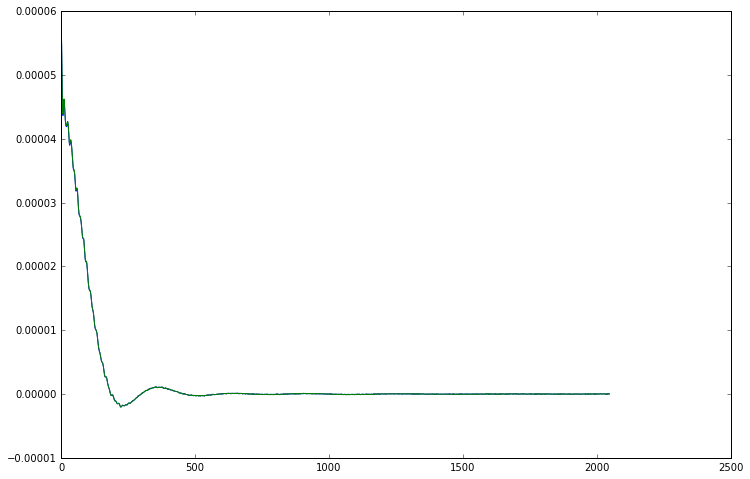

In [13]:
# first calculate the weights for each channel using the SVD method
channel_weights = suspect.processing.channel_combination.svd_weighting(repetition_averaged_data)
# apply the calculated weights to the data
cc_data = suspect.processing.channel_combination.combine_channels(repetition_averaged_data, channel_weights)
# the result is the same as our original, manually processed FID
plt.plot(cc_data.real)
plt.plot(channel_combined_data.real)

In the `channel_combination` module, the channel weights can be calculated using the `svd_weighting()` function while the `combine_channels()` function applies those weights to a set of FIDs. The decision to use two functions rather than a single function which performs both steps was made to improve the flexibility of the library. By splitting the functionality it makes it easy to calculate the channel weights in a different way if necessary, or to apply one set of weights to multiple datasets. For example when an unsuppressed water reference is acquired the weights calculated using that data can also be applied to the water suppressed data, while taking advantage of the much higher SNR of the unsuppressed acquisition.

So that concludes our look at channel combination for phased array MRS data. We have learned that the different channels need to be phase corrected, and that a weighted combination of the signals can significantly improve the overall SNR. We used the SVD method to calculate both the phase corrections and the optimal weights simultaneously, and seen how Suspect provides functions to make it easy to apply. Next time, we will look at B0 shifts and how to correct for them.